# Modelagem e arquitetura CNN

## Modelo de canal único Raw RGB pré treinado RESNET50 + IMAGENET (Top layers off)

### Conteúdo

- Ingestão
- Pré processamento
- Modelagem da rede
- Treinamento
- Teste
- Validação
- Resultados

### Importações e parâmetros

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
#import tensorflow_datasets as tfds
#tfds.disable_progress_bar()

videos_table_path = 'manual_frame_classification.csv'
videos_table_path_validation = 'manual_frame_validation.csv'
max_positive_cases = 5000
max_validation_cases = 10000
preprocess_training_test = True
preprocess_validation = False

### Ingestão

In [2]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_path(file_path):
    img = tf.io.read_file(file_path, )
    img = decode_img(img)
    return img

def process_label(label):
    return label == 'POS'

def process_dataframe(dataframe):
    xs = []
    ys = []
    with tf.device('/cpu:0'):
        for i,row in dataframe.iterrows():
            path = row['path']
            label = row['violence']
            xs.append(process_path(path))
            ys.append(process_label(label))
        return tf.data.Dataset.from_tensor_slices((xs,ys))

In [3]:
#IMPORT
frames_df = pd.read_csv(videos_table_path, sep=';', index_col=0)
video_list = frames_df[frames_df['load'] == 'X']['video'].unique()

#SEGREGATE
msk = np.random.rand(len(video_list)) < 0.9
train_test_videos = video_list[msk]
validation_videos =  video_list[~msk]
train_test_df = frames_df.loc[frames_df['video'].isin(train_test_videos)]
validation_df = frames_df.loc[frames_df['video'].isin(validation_videos)]

neg_df = train_test_df[train_test_df['violence'] == 'NEG'][['path','violence']]
pos_df = train_test_df[train_test_df['violence'] == 'POS'][['path','violence']]
neg_len = len(neg_df)
pos_len = len(pos_df)

#SHUFFLE
neg_df = neg_df.sample(frac=1).reset_index(drop=True)
pos_df = pos_df.sample(frac=1).reset_index(drop=True)
validation_df = validation_df.sample(frac=1).reset_index(drop=True)

#RESIZE
train_test_size = min([len(pos_df),max_positive_cases])
train_size = int(0.7*train_test_size)
test_size = train_test_size - train_size

pos_train_df = pos_df.head(train_size)
pos_test_df = pos_df.tail(test_size)

neg_train_df = neg_df.head(train_size)
neg_test_df = neg_df.tail(int(test_size*(neg_len/pos_len)))
                          
#MERGE
merged_train_df = pd.concat([pos_train_df, neg_train_df], ignore_index=True)
merged_test_df = pd.concat([pos_test_df, neg_test_df], ignore_index=True)
train_length = len(merged_train_df)
test_length = len(merged_test_df)
validation_length = len(validation_df)

print('Train dataset cases :' + str(train_length))
print('Test dataset cases :' + str(test_length))
print('Validation dataset cases :' + str(validation_length))

c:\users\red\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Train dataset cases :7000
Test dataset cases :21370
Validation dataset cases :27600


### Pré processamento

### Observações

Dataset claramente tendencioso (biased), será necessário tratar o desbalanceamento na fase de préprocessamento a fim de manter uma RN bem treinada.

#### Tarefas
- Separação do dataset em:
    - Dataset de treinamento (70%)
    - Dataset de teste (30%)

    
OBS: Todos os datasets devem estar balanceados! Portanto a medida balizadora será o gargalo atual: número de casos positivos. 

In [4]:
validation_df = pd.read_csv('validation_shuffled_df_resnet.csv', sep=';')
validation_length = len(validation_df)

In [4]:
#train_ds = None
#test_ds = None
#validation_ds = None

#RESHUFLE
if preprocess_training_test:
    shuffled_train_df = merged_train_df.sample(frac=1).reset_index(drop=True)
    shuffled_test_df = merged_test_df.sample(frac=2*test_size/test_length).reset_index(drop=True)

if preprocess_validation:
    validation_shuffled_df = validation_df.sample(frac=min(1,max_validation_cases/validation_length)).reset_index(drop=True)
    validation_length = len(validation_shuffled_df)

#PROCESS
if preprocess_training_test:
    train_ds = process_dataframe(shuffled_train_df)
    test_ds = process_dataframe(shuffled_train_df)
if preprocess_validation:
    validation_ds = process_dataframe(validation_shuffled_df)

#print('Train DataFrame size: ' + str(int(train_length)))
#print('Test DataFrame size: ' + str(int(test_length*2*test_size/test_length)))
#print('Validation DataFrame size: ' + str(int(validation_length)))

### Clear unused data
frames_df = None
neg_df = None
pos_df = None
#merged_df = None
shuffled_df = None
complete_dataset = None

In [5]:
validation_df.to_csv('validation_shuffled_df_resnet.csv', sep=';')

In [6]:
train_batches = train_ds.shuffle(100).batch(50)

### Ponto de execução para treinamento

Caso queira seguir com a criação do modelo executar os blocos a seguir

### Modelagem da CNN

In [27]:
# Create the base model from the pre-trained model ResNet50
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False

x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Sequential([base_model, 
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(100, activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(1, activation='sigmoid')]) #tf.keras.Model(base_model.input, x)

### Salvar modelo

In [28]:
base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]) #

In [9]:
model.save('cnn_resnet_pretrainned_raw_rgb_v1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: cnn_resnet_pretrainned_raw_rgb_v1\assets


### Carregar modelo

- OBS : Lembrar de ligar GPU

In [6]:
model = tf.keras.models.load_model('cnn_resnet_pretrainned_raw_rgb_v1')

In [29]:
history = model.fit_generator(train_batches, epochs=10)#, callbacks=[ tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)])

Train for 140 steps
Epoch 1/10
140/140 [==============================] - 29s 206ms/step - loss: 0.7065 - accuracy: 0.5297 - precision: 0.5630 - recall: 0.2654
Epoch 2/10
140/140 [==============================] - 26s 188ms/step - loss: 0.6916 - accuracy: 0.5053 - precision: 0.7846 - recall: 0.0146
Epoch 3/10
140/140 [==============================] - 27s 190ms/step - loss: 0.6918 - accuracy: 0.5043 - precision: 0.8261 - recall: 0.0109
Epoch 4/10
140/140 [==============================] - 27s 189ms/step - loss: 0.6885 - accuracy: 0.5287 - precision: 0.6779 - recall: 0.1094
Epoch 5/10
140/140 [==============================] - 26s 187ms/step - loss: 0.6899 - accuracy: 0.5091 - precision: 0.9211 - recall: 0.0200
Epoch 6/10
140/140 [==============================] - 26s 188ms/step - loss: 0.6901 - accuracy: 0.5091 - precision: 0.8636 - recall: 0.0217
Epoch 7/10
140/140 [==============================] - 26s 188ms/step - loss: 0.6900 - accuracy: 0.5094 - precision: 0.8511 - recall: 0.0229


## Training
Lr = 0.0001

loss: 0.5205 - accuracy: 0.9646 - precision: 0.9670 - recall: 0.9620 (11/07/20) -1
loss: 0.5189 - accuracy: 0.9686 - precision: 0.9686 - recall: 0.9686 (11/07/20) -2
loss: 0.5047 - accuracy: 0.9973 - precision: 0.9971 - recall: 0.9974 (11/07/20) -3

30s/época

### Salvar modelo

In [11]:
model.save('cnn_resnet_pretrainned_raw_rgb_v1')

INFO:tensorflow:Assets written to: cnn_resnet_pretrainned_raw_rgb_v1\assets


### Fine tunning

In [ ]:
model.trainable = True
history = model.fit_generator(train_batches, epochs=100, callbacks=[ tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)])

Train for 140 steps
Epoch 1/100
140/140 [==============================] - 34s 245ms/step - loss: 0.5169 - accuracy: 0.9744 - precision: 0.9792 - recall: 0.9693
Epoch 2/100
140/140 [==============================] - 34s 244ms/step - loss: 0.5164 - accuracy: 0.9761 - precision: 0.9798 - recall: 0.9722
Epoch 3/100
140/140 [==============================] - 34s 244ms/step - loss: 0.5159 - accuracy: 0.9781 - precision: 0.9835 - recall: 0.9725
Epoch 4/100
140/140 [==============================] - 34s 246ms/step - loss: 0.5157 - accuracy: 0.9770 - precision: 0.9818 - recall: 0.9719
Epoch 5/100
140/140 [==============================] - 34s 246ms/step - loss: 0.5161 - accuracy: 0.9763 - precision: 0.9798 - recall: 0.9725
Epoch 6/100
140/140 [==============================] - 34s 245ms/step - loss: 0.5166 - accuracy: 0.9749 - precision: 0.9820 - recall: 0.9673
Epoch 7/100
140/140 [==============================] - 34s 245ms/step - loss: 0.5157 - accuracy: 0.9777 - precision: 0.9801 - recall: 

In [12]:
import pickle
with open('trainHistoryDictresnet-3.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# Avaliação do modelo
## Dataset de teste

In [30]:
features = np.array([list(x[0].numpy()) for x in list(test_ds)])
labels = np.array([x[1].numpy() for x in list(test_ds)])
test_loss, test_acc, test_prec, test_rec = model.evaluate(x=features, y=labels, verbose=1, batch_size=None)

print('\nTest accuracy:', test_acc)
print('\nTest precision:', test_prec)
print('\nTest recall:', test_rec)

7000/7000 [==============================] - 20s 3ms/sample - loss: 0.6931 - accuracy: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+006s - loss: 0.

Test accuracy: 0.5

Test precision: 0.0

Test recall: 0.0


## Test

Lr = 0.0001

Test accuracy: 0.5 Test precision: 0.0 Test recall: 0.0 (11/07/20) - 1

## Dataset de validação

In [25]:
features = None
labels = None

In [7]:
features = np.array([list(x[0].numpy()) for x in list(validation_ds)])
labels = np.array([x[1].numpy() for x in list(validation_ds)])

In [17]:
pred = model.predict_classes(features, batch_size=None)

In [21]:
list(pred)

[array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),

In [17]:
#test_loss, test_acc, test_prec, test_rec = model.evaluate(x=features, y=labels, verbose=1, batch_size=None)

print('\nValidation accuracy:', test_acc)
print('\nValidation precision:', precision_score(labels, ~pred.astype(bool)))
print('\nValidation recall:', recall_score(labels, ~pred.astype(bool)))

10000/10000 [==============================] - 32s 3ms/sample - loss: 0.6931 - accuracy: 0.9110 - precision: 0.0000e+00 - recall: 0.0000e+00

Validation accuracy: 0.911

Validation precision: 0.0

Validation recall: 0.0


In [29]:
print('\nValidation accuracy:', accuracy_score())
print('\nValidation precision:', precision_score(labels, ~pred.astype(bool)))
print('\nValidation recall:', recall_score(labels, ~pred.astype(bool)))


Validation accuracy: 0.911

Validation precision: 0.3518005540166205

Validation recall: 0.14269662921348314


## Validation

Lr = 0.0001

Validation accuracy: 0.911 Validation precision: 0.3518005540166205 Validation recall: 0.14269662921348314 (11/07/20) - 1

100 Épocas de treinamento (7000 instâncias de treinamento)

Test accuracy: 0.9406667

Test precision: 0.95264244

Test recall: 0.9271877


Dataset de validação (10000 instâncias de frames de vídeos aleatórios não utilizados no treinamento)

Validation accuracy: 0.8686

Validation precision: 0.3448276

Validation recall: 0.5274972

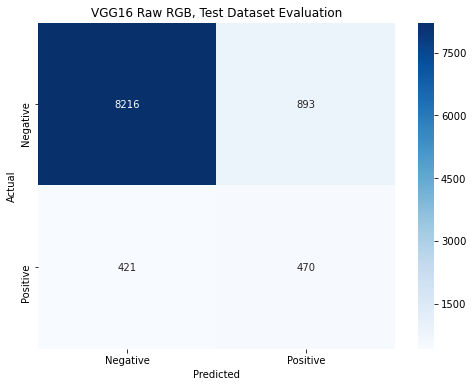

In [9]:
c_labels = [int(x) for x in labels]
predictions = model.predict_classes(features, batch_size=None)
pred = [x[0] for x in list(predictions)]
mat = tf.math.confusion_matrix(c_labels, pred)
df = pd.DataFrame(mat.numpy(), columns=['AP','AN'], index=['PP','PN'])
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df, cmap="Blues", annot=True, fmt="d", xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
ax.set_ylim([2,0])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('VGG16 Raw RGB, Test Dataset Evaluation')
plt.show()

In [18]:
mat

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[2841,   99],
       [  75, 2854]])>

In [15]:
pred.count(0)

9828

In [11]:
tf.math.confusion_matrix?

Signature:
tf.math.confusion_matrix(
    labels,
    predictions,
    num_classes=None,
    weights=None,
    dtype=tf.int32,
    name=None,
)
Docstring:
Computes the confusion matrix from predictions and labels.

The matrix columns represent the prediction labels and the rows represent the
real labels. The confusion matrix is always a 2-D array of shape `[n, n]`,
where `n` is the number of valid labels for a given classification task. Both
prediction and labels must be 1-D arrays of the same shape in order for this
function to work.

If `num_classes` is `None`, then `num_classes` will be set to one plus the
maximum value in either predictions or labels. Class labels are expected to
start at 0. For example, if `num_classes` is 3, then the possible labels
would be `[0, 1, 2]`.

If `weights` is not `None`, then each prediction contributes its
corresponding weight to the total value of the confusion matrix cell.

For example:

```python
  tf.math.confusion_matrix([1, 2, 4], [2, 2, 4]) ==>